# Deep fake detection challenge

#### Setup tensorflow to use GPU if available

In [17]:
import tensorflow as tf
import os

gpu = False
# Use gpu if available
if gpu:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    physical_devices = tf.config.list_physical_devices('GPU')
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    print(os.environ['CUDA_VISIBLE_DEVICES'])  # Check the value

#### Setup the seed for random number generators to ensure reproducibility

In [18]:
import random
import numpy as np
# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Pre-Procesing

### Step 1

- Load the data from the directory
- Extract 20 random frames from each video
- Use MTcnn to detect faces in the frames. If no face is detected, discard the frame. If more than one face is detected, take the first face since both faces have been faked similarly.
- Resize the frames to 224x224
- Save the frames in a new directory and create a new image_label.json file

This step takes a long time (174 min running on a Tesla V100-PCIE-32GB GPU).
Therefore we do this only once and save the processed images to a new directory.

In [19]:
import cv2
import imageio
import os
import random
import json
from mtcnn import MTCNN

# Paths
data_folder = "data"
output_folder = "data_images"

# If the output folder is not empty, skip processing
if os.path.exists(output_folder) and len(os.listdir(output_folder)) > 0:
    print("Skipping processing: 'data_images' folder is already populated.")
else:
    os.makedirs(output_folder, exist_ok=True)


    # Initialize MTCNN
    detector = MTCNN()

    # Parameters
    num_frames = 20
    frame_size = (224, 224)

    # Load labels from the existing metadata
    with open("data/metadata.json", "r") as f:
        video_labels = json.load(f)

    # Dictionary to store image-label mappings
    image_labels = {}

    # Process videos
    for video_name in os.listdir(data_folder):
        video_path = os.path.join(data_folder, video_name)

        if video_name.endswith(".mp4"):
            reader = imageio.get_reader(video_path, "ffmpeg")
            total_frames = reader.count_frames()

            # Select frame indices
            selected_frame_indices = sorted(random.sample(range(total_frames), num_frames))

            # Extract frames and process
            for i, frame in enumerate(reader):
                if i in selected_frame_indices:
                    frame_rgb = frame
                    if frame.ndim == 2:  # if grayscale
                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
                    elif frame.shape[2] == 4:  # if RGBA
                        frame_rgb = frame[:, :, :3]
                    # Detect faces in the frame and choose the first face
                    faces = detector.detect_faces(frame)
                    
                    # If no faces are found, skip this frame
                    if len(faces) == 0:
                        continue

                    # Get the bounding box of the first face
                    face = faces[0]
                    x, y, w, h = face['box']

                    # Crop the face region
                    face_crop = frame[y:y+h, x:x+w]
                    
                    if face_crop.size == 0:  # Ensure the cropped face is valid
                        continue
                    
                    # Resize the cropped face to 224x224
                    face_resized = cv2.resize(face_crop, frame_size)

                    # Generate a unique image name for the face
                    image_name = f"{video_name.split('.')[0]}_{i}.jpg"
                    image_path = os.path.join(output_folder, image_name)

                    # Save the resized face image
                    cv2.imwrite(image_path, face_resized)

                    # Store the label mapping
                    video_metadata = video_labels.get(video_name)
                    if video_metadata:
                        image_labels[image_name] = video_metadata["label"]

            reader.close()

    # Save the label mappings to a JSON file
    with open("image_labels.json", "w") as f:
        json.dump(image_labels, f, indent=4)

    print("Processing complete. Images saved in 'data_images', labels in 'image_labels.json'.")



Skipping processing: 'data_images' folder is already populated.


### Image Label Counts Plot
- The plot above visualizes the count of `REAL` and `FAKE` videos that have been processed in the pre-processing step. Keep in mind that the number of images is 20 times the number of videos.


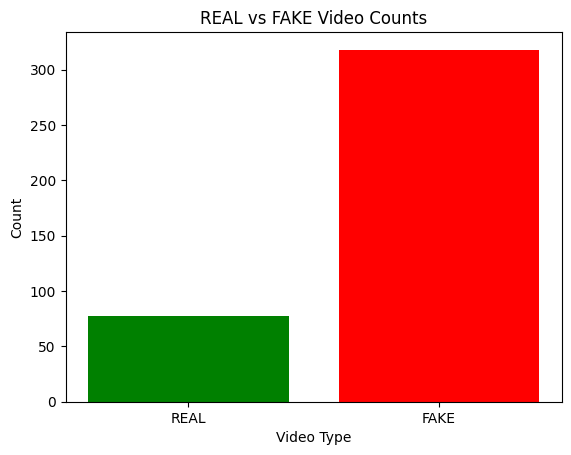

In [20]:
import matplotlib.pyplot as plt

image_labels = json.load(open("image_labels.json", "r"))

movie_labels = {}

for filename, label in image_labels.items():
    movie_name = filename.split("_")[0]  # Extract movie name
    movie_labels[movie_name] = label  # Store only one label per movie
    
# Count the number of unique REAL and FAKE videos
real_movies_count = sum(1 for label in movie_labels.values() if label == "REAL")
fake_movies_count = sum(1 for label in movie_labels.values() if label == "FAKE")

# Plotting the results
labels = ['REAL', 'FAKE']
counts = [real_movies_count, fake_movies_count]

plt.bar(labels, counts, color=['green', 'red'])
plt.xlabel('Video Type')
plt.ylabel('Count')
plt.title('REAL vs FAKE Video Counts')
plt.show()

### Step 2

- Assign the videos to fakes and reals classes

In [21]:
# load the images and labels and set it to a tf.data.Dataset

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

fakes = np.empty((0, 2), dtype=object)
reals = np.empty((0, 2), dtype=object)

for image, label in movie_labels.items():
    if label == "FAKE":
        
        fakes = np.append(fakes, np.array([[image, label]]), axis=0)
    else:
        reals = np.append(reals, np.array([[image, label]]), axis=0)
        
data = np.vstack((fakes, reals))

#### Perorm train-test split on the movies while stratifying on the labels. This is very important to spit by the videos and not by the frames to avoid data leakage between the train and test sets.


In [22]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=SEED, stratify=data[:, 1])

train, val = train_test_split(train, test_size=0.2, random_state=SEED, stratify=train[:, 1])


### Since we split by the videos we need to assign the corresponding images to the train and test sets

In [23]:
# Convert to sets for quick lookup
train_movies = set(train[:, 0])
val_movies = set(val[:, 0])
test_movies = set(test[:, 0])

# Function to filter images based on movie set
def get_images_from_movies(movie_set, image_labels):
    return np.array([[img, label] for img, label in image_labels.items() if img.split("_")[0] in movie_set], dtype=object)

# Filter images for each dataset
train_images = get_images_from_movies(train_movies, image_labels)
val_images = get_images_from_movies(val_movies, image_labels)
test_images = get_images_from_movies(test_movies, image_labels)

#### Plot the total number of images in each class


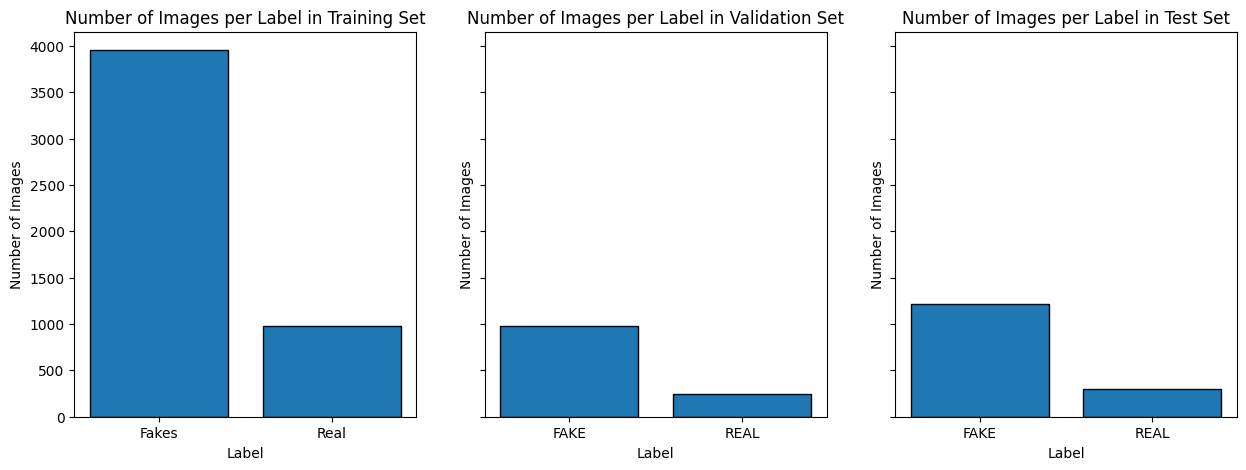

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

unique_labels, label_counts = np.unique(train_images[:, 1], return_counts=True)
axes[0].bar(unique_labels, label_counts, edgecolor='black')
axes[0].set_xticks(unique_labels)
axes[0].set_xticklabels(['Fakes', 'Real'])
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Number of Images per Label in Training Set')

unique_labels, label_counts = np.unique(val_images[:, 1], return_counts=True)
axes[1].bar(unique_labels, label_counts, edgecolor='black')
axes[1].set_xticks(unique_labels)
axes[0].set_xticklabels(['Fakes', 'Real'])
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Number of Images')
axes[1].set_title('Number of Images per Label in Validation Set')

unique_labels, label_counts = np.unique(test_images[:, 1], return_counts=True)
axes[2].bar(unique_labels, label_counts, edgecolor='black')
axes[2].set_xticks(unique_labels)
axes[0].set_xticklabels(['Fakes', 'Real'])
axes[2].set_xlabel('Label')
axes[2].set_ylabel('Number of Images')
axes[2].set_title('Number of Images per Label in Test Set')

# Display the plot
plt.show()

#### Save the images under train, test and val folders with the respective labels in the folder name

Mapping the labels to integers:

REAL → 0

FAKE → 1

In [25]:
from PIL import Image

# Mapping labels
label_mapping = {"REAL": 0, "FAKE": 1}


def save_images(data, base_folder):
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)
    for img_path, label in data:
        # Convert label to 0 or 1
        numeric_label = label_mapping[label]
        
        label_folder = os.path.join(base_folder, str(numeric_label))
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)
        img = Image.open("data_images/" + img_path)
        img.save(os.path.join(label_folder, os.path.basename(img_path)))

if os.path.exists('train') and os.path.exists('val') and os.path.exists('test') and len(os.listdir(output_folder)) > 0:
    print("Skipping processing: 'train, val, test' folder is already full.")
else:
    # Save the images for each dataset
    save_images(train_images, 'train')
    save_images(val_images, 'val')
    save_images(test_images, 'test')

Skipping processing: 'train, val, test' folder is already full.


## SSIM Masks

### Take the mean of all the real images from the train dataset 

In [26]:
def SSIM_Avg():    
    # --- Calculate average real image for SSIM ---
    real_train_dir = os.path.join('train', '0')  # Assuming '0' is REAL class
    real_image_files = [os.path.join(real_train_dir, f) for f in os.listdir(real_train_dir)]

    # Compute average of all real training images
    avg_real_image = np.zeros((224, 224), dtype=np.float32)
    for img_file in real_image_files:
        img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (224, 224))
            avg_real_image += img.astype(np.float32)
    avg_real_image /= len(real_image_files)
    avg_real_image = avg_real_image.astype(np.uint8)
    return avg_real_image

### Use this average image and calculate the SSIM between this and all the images in the dataset and save the SSIM values in a dictionary

In [27]:
from skimage.metrics import structural_similarity as ssim

def precompute_ssim_masks(dataset_dir, save_dir, avg_real_image):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for label in os.listdir(dataset_dir):
        label_dir = os.path.join(dataset_dir, label)
        label_save_dir = os.path.join(save_dir, label)
        os.makedirs(label_save_dir, exist_ok=True)  # Create label directory

        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                img = cv2.resize(img, (224, 224))

                # Compute SSIM map
                _, ssim_map = ssim(img, avg_real_image, full=True)

               # Normalize to [0,1] and save as float32 numpy array
                ssim_map = (ssim_map - ssim_map.min()) / (ssim_map.max() - ssim_map.min())
                mask_path = os.path.join(label_save_dir, f"{os.path.splitext(img_file)[0]}.npy")
                np.save(mask_path, ssim_map.astype(np.float32))
                
# Precompute SSIM masks for each dataset
if os.path.exists('train_ssim') and os.path.exists('val_ssim') and os.path.exists('test_ssim'):
    print("Skipping processing: 'train_ssim, val_ssim, test_ssim' folder is already full.")
else:
    # Save the images for each dataset
    avg_real_image = SSIM_Avg()
    precompute_ssim_masks("train", 'train_ssim', avg_real_image)
    precompute_ssim_masks("val", 'val_ssim', avg_real_image)
    precompute_ssim_masks("test", 'test_ssim', avg_real_image)


Skipping processing: 'train_ssim, val_ssim, test_ssim' folder is already full.


#### Load the images from the folders and perform data augmentation


In [79]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
# Create ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0, 1]
    rotation_range=10,           # Randomly rotate images by up to 10 degrees
    width_shift_range=0.1,       # Randomly shift images horizontally by 10% of the width
    height_shift_range=0.1,      # Randomly shift images vertically by 10% of the height
    shear_range=0.2,             # Apply shearing transformations
    zoom_range=0.1,              # Randomly zoom in or out by 20%
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Fill missing pixels after transformations,

)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# Create generators
train_generator = train_datagen.flow_from_directory(
    'train',                   
    target_size=(224, 224),     
    batch_size=batch_size,              
    class_mode='binary'    
)

val_generator = val_datagen.flow_from_directory(
    'val', 
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    'test', 
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

Found 4936 images belonging to 2 classes.
Found 1220 images belonging to 2 classes.
Found 1516 images belonging to 2 classes.


### Make a dual data generator to include the SSIM Masks as an additional input to the model

In [81]:
def dual_input_generator(base_gen, ssim_dir):
    while True:
        batch_x, batch_y = next(base_gen)
        
        batch_ssim = []
        # Get the actual filepaths used for this batch
        current_indices = base_gen.index_array[
            (base_gen.batch_index - 1) * base_gen.batch_size : 
            base_gen.batch_index * base_gen.batch_size
        ]
        
        for i in current_indices:
            img_path = base_gen.filepaths[i]
            rel_path = os.path.relpath(img_path, base_gen.directory)
            mask_path = os.path.join(ssim_dir, os.path.splitext(rel_path)[0] + '.npy')
            
            # Load and process efficiently
            ssim_map = np.load(mask_path)
            ssim_map = cv2.resize(ssim_map, base_gen.target_size)
            batch_ssim.append(ssim_map[..., np.newaxis].astype(np.float16))
        
        # Ensure consistent batch size
        if len(batch_x) != len(batch_ssim):
            continue
            
        #yield [batch_x, np.array(batch_ssim)], batch_y
        yield [tf.convert_to_tensor(batch_x), tf.convert_to_tensor(np.array(batch_ssim))], tf.convert_to_tensor(batch_y)


# Create final generators
train_generator_dual = dual_input_generator(train_generator, 'train_ssim')
val_generator_dual = dual_input_generator(val_generator, 'val_ssim')
test_generator_dual = dual_input_generator(test_generator, 'test_ssim')

In [82]:
import tensorflow as tf
import os
import numpy as np
import cv2

def dual_input_generator(base_gen, ssim_dir):
    while True:
        batch_x, batch_y = next(base_gen)
        
        batch_ssim = []
        # Get the actual filepaths used for this batch
        current_indices = base_gen.index_array[
            (base_gen.batch_index - 1) * base_gen.batch_size : 
            base_gen.batch_index * base_gen.batch_size
        ]
        
        for i in current_indices:
            img_path = base_gen.filepaths[i]
            rel_path = os.path.relpath(img_path, base_gen.directory)
            mask_path = os.path.join(ssim_dir, os.path.splitext(rel_path)[0] + '.npy')
            
            # Load and process efficiently
            ssim_map = np.load(mask_path)
            ssim_map = cv2.resize(ssim_map, base_gen.target_size)
            batch_ssim.append(ssim_map[..., np.newaxis].astype(np.float32))  # Changed to float32 for better compatibility
        
        # Ensure consistent batch size
        if len(batch_x) != len(batch_ssim):
            continue
            
        # Convert to tensors and return with proper structure
        yield (tf.convert_to_tensor(batch_x), tf.convert_to_tensor(np.array(batch_ssim))), tf.convert_to_tensor(batch_y)

# Create final generators with output signatures
def get_generator_signature():
    # Define the output signature
    image_spec = tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)
    ssim_spec = tf.TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32)
    label_spec = tf.TensorSpec(shape=(None,), dtype=tf.float32)
    
    return ((image_spec, ssim_spec), label_spec)

# Create generators with proper output signatures
train_generator_dual = tf.data.Dataset.from_generator(
    lambda: dual_input_generator(train_generator, 'train_ssim'),
    output_signature=get_generator_signature()
)

val_generator_dual = tf.data.Dataset.from_generator(
    lambda: dual_input_generator(val_generator, 'val_ssim'),
    output_signature=get_generator_signature()
)

test_generator_dual = tf.data.Dataset.from_generator(
    lambda: dual_input_generator(test_generator, 'test_ssim'),
    output_signature=get_generator_signature()
)

# Model

In [83]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight("balanced", classes=np.array([0, 1]), y=train_generator.classes)

# Convert to dictionary format for Keras
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Computed class weights:", class_weight_dict)

Computed class weights: {0: np.float64(2.5183673469387755), 1: np.float64(0.6238624873609707)}


## Lightweight Model

In [84]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.models import Model

# Input shape (match your generator output)
input_shape = (224, 224)

# 1. RGB Branch (MobileNetV2)
rgb_input = Input(shape=(*input_shape, 3))
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_tensor=rgb_input,
    pooling='avg'
)

base_model.trainable = False
for layer in base_model.layers[-10:]:  # Unfreeze last 10 layers, for example
    layer.trainable = True

rgb_features = base_model.output  # Shape: (None, 1280)

# 2. SSIM Branch (Simplified)
ssim_input = Input(shape=(*input_shape, 1))
x = Conv2D(16, (3,3), activation='relu')(ssim_input)
x = MaxPooling2D(4)(x)  # 56x56
x = Conv2D(32, (3,3), activation='relu')(x)
x = MaxPooling2D(4)(x)  # 14x14
x = Conv2D(64, (3,3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)  # Shape: (None, 64)

# 3. Combine features
combined = Concatenate()([rgb_features, x])  # Now shapes match: (None, 1280) + (None, 64)

# 4. Classification head
output = Dense(1, activation='sigmoid')(combined)

model = Model(inputs=[rgb_input, ssim_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

C:\Users\shegg\AppData\Local\Temp\ipykernel_31872\125760513.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


In [85]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint_cb = ModelCheckpoint("best_model.h5", 
                                monitor="val_loss", 
                                save_best_only=True, 
                                mode="min", 
                                verbose=1)

early_stopping_cb = EarlyStopping(monitor="val_loss", 
                                  patience=5,  # Stop if val_loss doesn't improve for 5 epochs
                                  restore_best_weights=True, 
                                  verbose=1)


In [86]:
history = model.fit(
    train_generator_dual,
    steps_per_epoch=len(train_generator),  # Use original generator's length
    validation_data=val_generator_dual,
    validation_steps=len(val_generator),   # Use original generator's length
    epochs=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/2


309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.6777 - loss: 0.6292
Epoch 1: val_loss improved from inf to 0.97778, saving model to best_model.h5


309/309 ━━━━━━━━━━━━━━━━━━━━ 111s 347ms/step - accuracy: 0.6778 - loss: 0.6289 - val_accuracy: 0.7110 - val_loss: 0.9778
Epoch 2/2
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8041 - loss: 0.4317
Epoch 2: val_loss improved from 0.97778 to 0.52472, saving model to best_model.h5


309/309 ━━━━━━━━━━━━━━━━━━━━ 66s 213ms/step - accuracy: 0.8041 - loss: 0.4317 - val_accuracy: 0.8312 - val_loss: 0.5247
Restoring model weights from the end of the best epoch: 2.


In [87]:
predictions = model.predict(test_generator_dual, steps=len(test_generator), verbose=1)


95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 246ms/step


### Round the predictions to 0 or 1 given a threshold of 0.5

In [88]:
threshold = 0.5
predicted_classes = (predictions > threshold).astype(int).flatten()  # Convert to binary (0/1)

### Compute video predictions by averaging the frame predictions for each video and output a single prediction for each video given a tresold of 0.5

In [89]:
import pandas as pd

def get_video_prediction(predictions, threshold=0.5):
    # Extract video names from image filenames
    image_filenames = test_generator.filenames  # From your test generator
    video_names = [os.path.splitext(os.path.basename(f))[0].split('_')[0] for f in image_filenames]
    

    true_value = test_generator.classes  # True labels
    # Use the equal video names index to get the predictions for each video
    video_predictions = {}
    true_labels  = {}
    for video, pred in zip(video_names, predictions):
        if video not in video_predictions:
            video_predictions[video] = [pred]
        else:
            video_predictions[video].append(pred)
        true_labels [video] = true_value[video_names.index(video)]
        
    # Calculate the total prediction for each video given the threshold
    video_preds = {}

    for video, preds in video_predictions.items():
        avg_pred = np.mean(preds)
        video_preds[video] = int(avg_pred > threshold)
    
    videos = sorted(video_preds.keys())
    y_pred = np.array([video_preds[v] for v in videos])
    y_true = np.array([true_labels[v] for v in videos])
    
    # Return the final predictions and true values as numpy arrays
    return y_true, y_pred

# Get predictions
video_predictions, video_true_value = get_video_prediction(predicted_classes)


### Compute the accuracy, precision, recall and F1 score for the video predictions along with a plot of the confusion matrix

<Figure size 800x600 with 0 Axes>

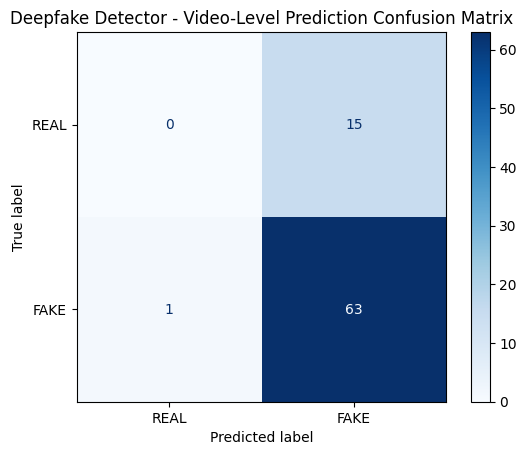


Classification Metrics:
Accuracy  : 0.7975
Precision : 0.8077
Recall    : 0.9844
F1        : 0.8873


In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                            precision_score, recall_score, 
                            accuracy_score, roc_auc_score, f1_score)

def evaluate_video_predictions(y_true, y_pred, class_names=["REAL", "FAKE"], model_name="Model"):

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"{model_name} - Video-Level Prediction Confusion Matrix")
    plt.show()
    
    # Print metrics
    print("\nClassification Metrics:")
    for name, value in metrics.items():
        print(f"{name.capitalize():<10}: {value:.4f}")
    
    return metrics

# Evaluate
metrics = evaluate_video_predictions(
    y_true=video_predictions,
    y_pred=video_true_value,
    class_names=["REAL", "FAKE"],
    model_name="Deepfake Detector"
)


In [91]:
mapping_label = {0: 'REAL', 1: 'FAKE'}


### HeatMap

In [92]:
def get_grad_cam_dual_input(model, rgb_image, ssim_image, class_idx, layer_name='block_16_project'):
    """Generate Grad-CAM heatmap for dual-input model"""
    # Convert class_idx to integer and verify model output shape
    class_idx = int(class_idx)
    
    # Create gradient model
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    # Prepare inputs with proper shapes
    rgb_input = tf.cast(np.expand_dims(rgb_image, axis=0), tf.float32)  # [1, H, W, 3]
    ssim_input = tf.cast(np.expand_dims(ssim_image[..., np.newaxis], axis=0), tf.float32)  # [1, H, W, 1]
    
    with tf.GradientTape() as tape:
        # Get both outputs
        conv_outputs, predictions = grad_model([rgb_input, ssim_input])
        
        # Handle single-output models (binary classification)
        if predictions.shape[-1] == 1:
            loss = predictions[0]  # For binary classification
        else:
            loss = predictions[:, class_idx]  # For multi-class
    
    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    
    # Guided Grad-CAM
    cast_conv_outputs = tf.cast(conv_outputs > 0, "float32")
    cast_grads = tf.cast(grads > 0, "float32")
    guided_grads = cast_conv_outputs * cast_grads * grads
    
    # Weight the activation maps
    weights = tf.reduce_mean(guided_grads, axis=(0, 1, 2))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)
    
    # Process CAM
    cam = np.maximum(cam, 0)
    cam = cam[0]  # Take first (and only) item in batch
    cam = cam / (np.max(cam) + 1e-10)  # Normalize with small epsilon
    
    return cam


def overlay_heatmap(image, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """Overlay heatmap on image"""
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlayed = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return overlayed
# Get a test batch
(images, ssim_masks), labels = next(test_generator_dual)

# Select an example
idx = 0  # First in batch
rgb_image = images[idx]
ssim_image = ssim_masks[idx][..., 0]  # Remove channel dim
true_label = int(labels[idx])  # Convert to integer

# Generate heatmap - use last conv layer before pooling
heatmap = get_grad_cam_dual_input(
        model=model,
        rgb_image=rgb_image,
        ssim_image=ssim_image,
        class_idx=true_label,
        layer_name='block_16_project'  # Try different layers
    )
    
# Visualization
rgb_image_uint8 = (rgb_image * 255).astype(np.uint8)
overlay = overlay_heatmap(rgb_image_uint8, heatmap)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_image_uint8)
plt.title(f"Original (Class {true_label})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Grad-CAM Heatmap")
plt.axis('off')
plt.show()

TypeError: '_FlatMapDataset' object is not an iterator

In [53]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# 1. EfficientNet branch (RGB images)
rgb_input = Input(shape=(224, 224, 3))
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=rgb_input)

for layer in base_model.layers:
    layer.trainable = False  # Freeze EfficientNet layers for transfer learning

rgb_features = base_model.output  # Shape: (7, 7, 1280)

# 2. SSIM branch (Grayscale input)
ssim_input = Input(shape=(224, 224, 1))

x_ssim = Conv2D(32, (3,3), activation='relu', padding='same')(ssim_input)
x_ssim = MaxPooling2D((2,2))(x_ssim)  # (112, 112, 32)

x_ssim = Conv2D(64, (3,3), activation='relu', padding='same')(x_ssim)
x_ssim = MaxPooling2D((2,2))(x_ssim)  # (56, 56, 64)

x_ssim = Conv2D(128, (3,3), activation='relu', padding='same')(x_ssim)
x_ssim = MaxPooling2D((2,2))(x_ssim)  # (28, 28, 128)

x_ssim = Conv2D(256, (3,3), activation='relu', padding='same')(x_ssim)
x_ssim = MaxPooling2D((2,2))(x_ssim)  # (14, 14, 256)

x_ssim = Conv2D(512, (3,3), activation='relu', padding='same')(x_ssim)
x_ssim = MaxPooling2D((2,2))(x_ssim)  # (7, 7, 512)

# Match EfficientNet's output channels
x_ssim = Conv2D(1280, (1,1), activation='relu')(x_ssim)  # (7, 7, 1280)

# 3. Combine EfficientNet and SSIM features
combined = Concatenate()([rgb_features, x_ssim])  # (7, 7, 2560)

# 4. Classification head
x = GlobalAveragePooling2D()(combined)  # (2560,)
output = Dense(1, activation='sigmoid')(x)

# 5. Model definition
model = Model(inputs=[rgb_input, ssim_input], outputs=output)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                              